# Исследование результатов сервиса GO Fast.

GoFast компания предоставляет услуги проката в нескольких городах через мобильное приложение. Пользователи могут ездить:

Без подписки: старт — 50 ₽, минута — 8 ₽;

С подпиской Ultra: абонентская плата — 199 ₽ в месяц, без платы за старт, минута — 6 ₽.

Цель проекта — проанализировать поведение пользователей, выявить закономерности в использовании сервиса, и проверить гипотезы, которые помогут оптимизировать продукт, повысить выручку и улучшить пользовательский опыт.

Импортируем нужные библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
from scipy.stats import binom
from scipy.stats import norm

#### Шаг 1. Загрузка данных

In [2]:
from google.colab import files

# Загружаем сразу несколько файлов (можно выделить их при выборе)
uploaded = files.upload()

Saving subscriptions_go.csv to subscriptions_go (1).csv
Saving rides_go.csv to rides_go (1).csv
Saving users_go.csv to users_go (1).csv


In [3]:
# Показывает все столбцы датафрейма при выводе, не скрывая их
pd.set_option('display.max_columns', None)

In [4]:
users_go = pd.read_csv('users_go.csv')
rides_go = pd.read_csv('rides_go.csv')
subscriptions_go = pd.read_csv('subscriptions_go.csv')

Смотрим содержимое таблиц

In [5]:
display(users_go.head())
users_go.info()
display(rides_go.head())
rides_go.info()
display(subscriptions_go.head())
subscriptions_go.info()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


In [6]:
print('Записи с ', rides_go['date'].min(), 'по', rides_go['date'].max())

Записи с  2021-01-01 по 2021-12-30


В таблице записи за 2021 год.

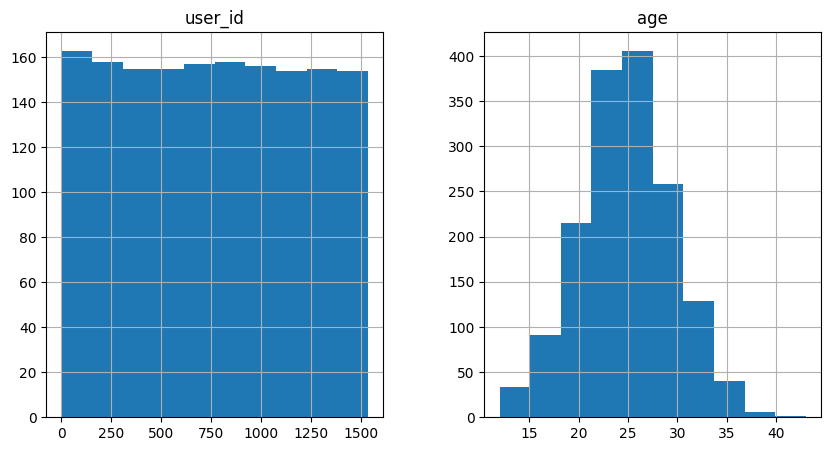

In [7]:
users_go.hist(figsize=(10, 5));

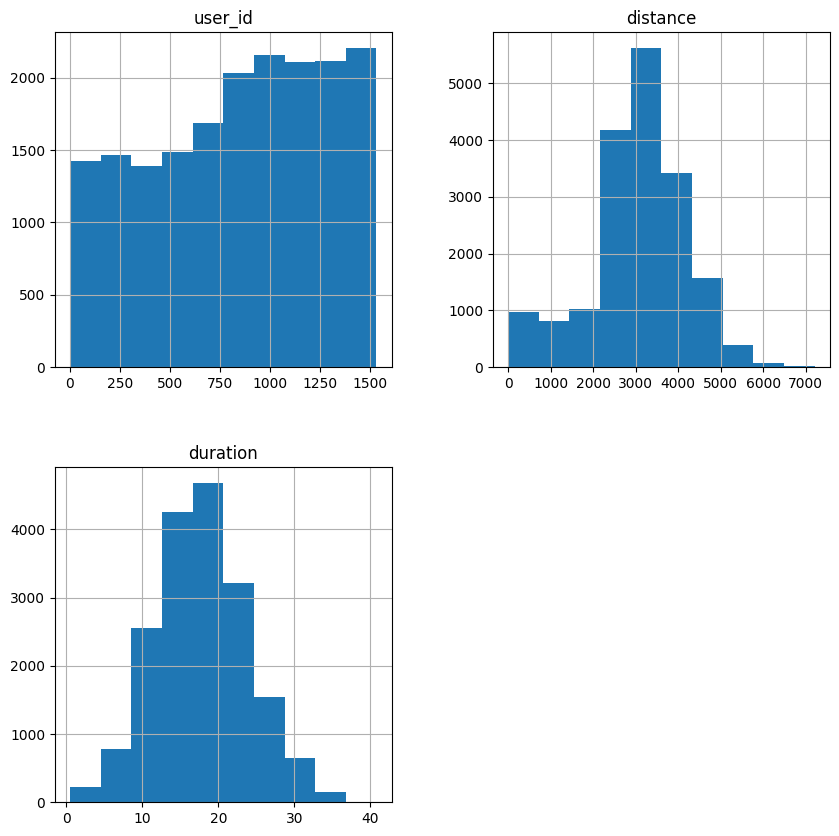

In [8]:
rides_go.hist(figsize=(10, 10));

Видим, что в 3 датасетах отсутсвуют пропуски. В юзерах 1565 записей. В поездках 18068 записей. В типе подписки 2 записи.

#### Шаг 2. Предобработка данных

2.1 Приведите столбец date к типу даты pandas. 2.2 Создайте новый столбец с номером месяца на основе столбца date. 2.3 Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

In [9]:
rides_go['date'] = pd.to_datetime(rides_go['date'])
rides_go['month'] = rides_go['date'].dt.month

rides_go.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [10]:
print(users_go.duplicated().sum())
print(rides_go.duplicated().sum())
print(subscriptions_go.duplicated().sum())

31
0
0


In [11]:
# Удаляем явные дубликаты
users_go = users_go.drop_duplicates().reset_index()

In [12]:
rides_go['distance'] = rides_go['distance'].round(2)
rides_go['duration'] = np.ceil(rides_go['duration']).astype('int')

Добавили столбец с месяцем в таблицу с поездками. Удалили явные дубликаты в таблице с пользователями. Округлили до 2 значений после запятой столбец с расстоянием, столбец продолжительности поездки привели к целому числу округленному в большую сторону.

Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках: 3.1 частота встречаемости городов; 3.2 соотношение пользователей с подпиской и без подписки; 3.3 возраст пользователей; 3.4 расстояние, которое пользователь преодолел за одну поездку; 3.5 продолжительность поездок.

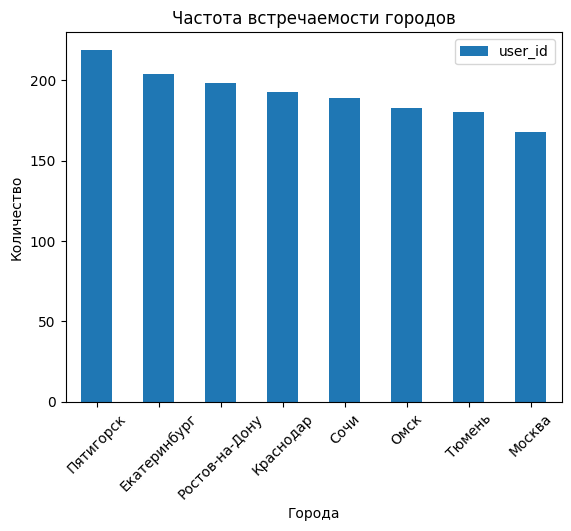

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [13]:
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False).plot(kind='bar')
plt.title('Частота встречаемости городов')
plt.xlabel('Города')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

Пятигорск чаще всего встречается, москва реже всех.

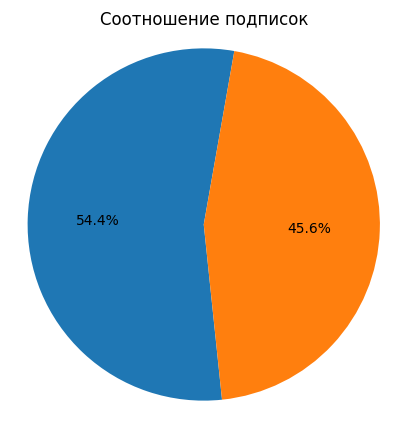

In [14]:
plt.figure(figsize=(5, 5))
plt.pie((users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count'))['user_id'], autopct='%1.1f%%', startangle=80)
plt.title('Соотношение подписок')
plt.axis('equal')
plt.show()

Пользователей больше без подписки.

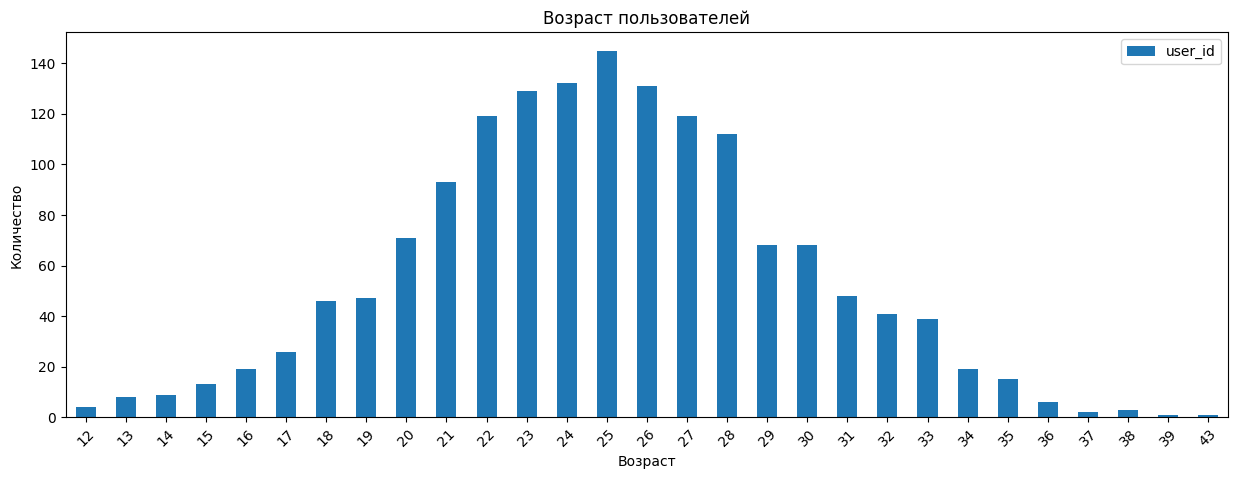

,user_id
age,
43,1
39,1
38,3
37,2
36,6
35,15
34,19
33,39
32,41


In [15]:
(
users_go.pivot_table(index='age', values='user_id', aggfunc='count')
    .sort_values(by='age')
    .plot(kind='bar', figsize=(15,5))
)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()
(
users_go.pivot_table(index='age', values='user_id', aggfunc='count')
    .sort_values(by='age', ascending=False)
)

In [16]:
users_go.pivot_table(index='age', values='user_id', aggfunc='count').describe()

,user_id
count,29.000000
mean,52.896552
std,48.824280
min,1.000000
25%,9.000000
50%,41.000000
75%,93.000000
max,145.000000


Самый частый возраст среди пользователей 21-28.

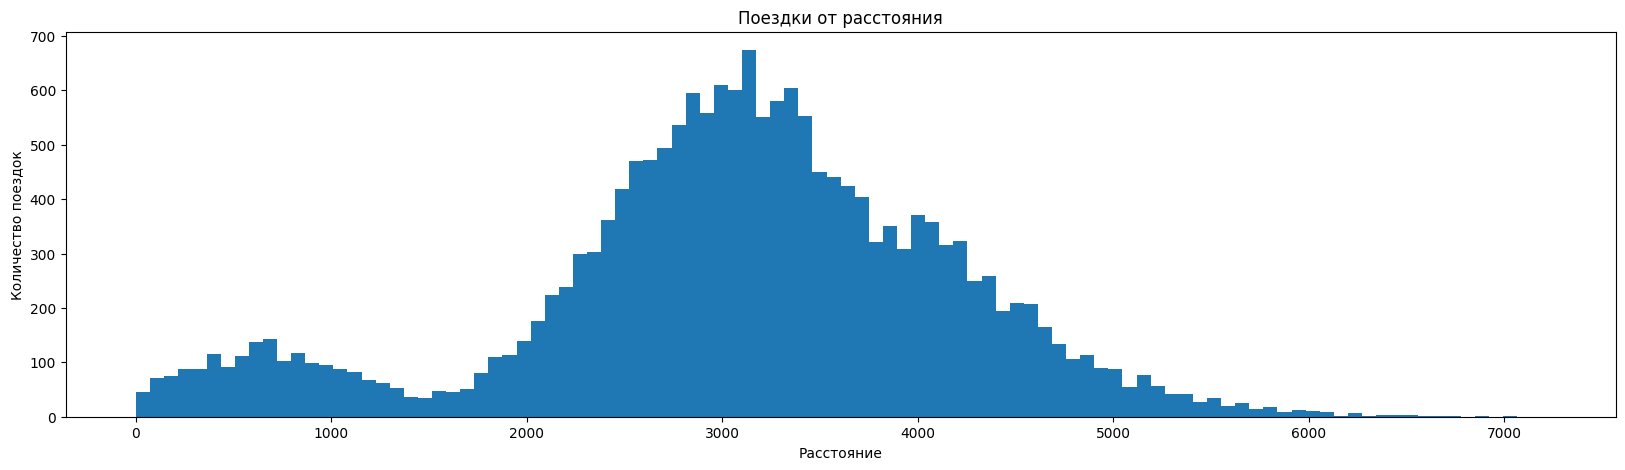

,distance
count,18068.000000
mean,3070.659992
std,1116.831222
min,0.860000
25%,2543.227500
50%,3133.610000
75%,3776.220000
max,7211.010000


In [17]:
plt.figure(figsize=(20, 5))
plt.hist(rides_go['distance'], bins=100, range=(1, 7211))
plt.title('Поездки от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

rides_go['distance'].describe()

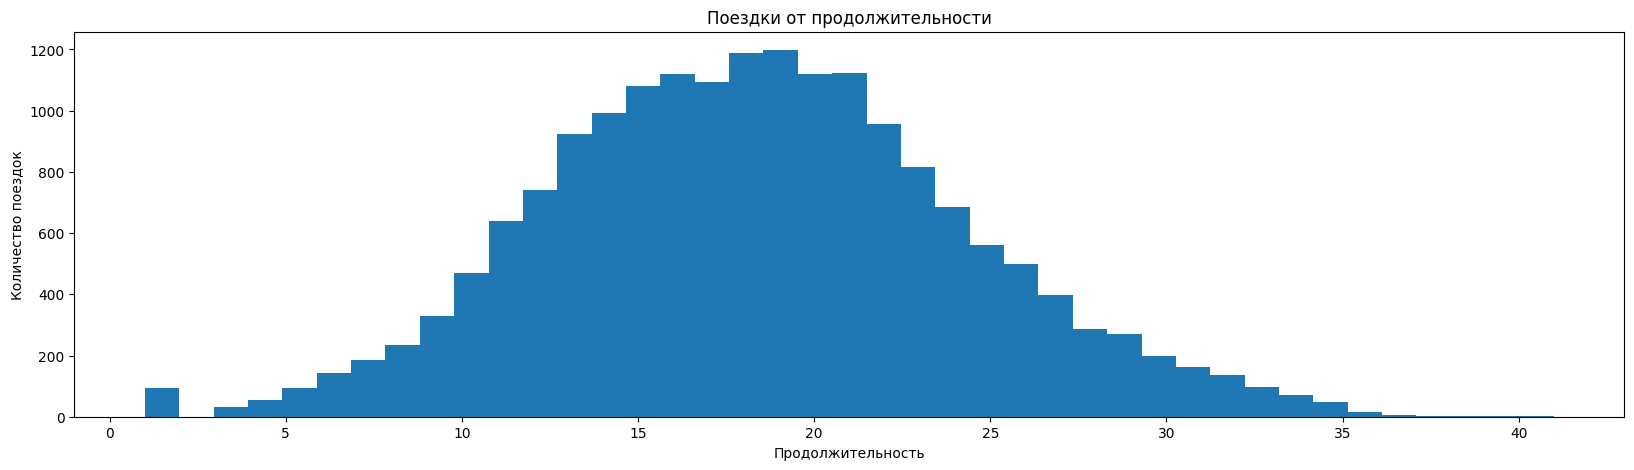

,duration
count,18068.000000
mean,18.303520
std,6.094928
min,1.000000
25%,14.000000
50%,18.000000
75%,22.000000
max,41.000000


In [18]:
plt.figure(figsize=(20, 5))
plt.hist(rides_go['duration'], bins=41, range=(1, 41))
plt.title('Поездки от продолжительности')
plt.xlabel('Продолжительность')
plt.ylabel('Количество поездок')
plt.show()

rides_go['duration'].describe()

Средняя продолжительность поездки 15-22минуты.

Вывод: Самый часто встречаемый город - Пятигорск, реже всех - Москва. Пользователей с подпиской - 699, без подписки - 835. Самый частый возраст среди пользователей 21-28. Больше всего поездок на расстояние примерно 3км, а продолжительность 20 минут.

#### Шаг 4. Объединение данных

4.1 Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge(). 4.2 Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1: c данными о пользователях без подписки; с данными о пользователях с подпиской. 4.3 Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [19]:
data = pd.merge(users_go, subscriptions_go, on='subscription_type')
data = pd.merge(rides_go, data, on='user_id')
data.head()

,user_id,distance,duration,date,month,index,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.92,26,2021-01-01,1,0,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.59,16,2021-01-18,1,0,Кира,22,Тюмень,ultra,6,0,199
2,1,754.16,7,2021-04-20,4,0,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.78,19,2021-08-11,8,0,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.69,27,2021-08-28,8,0,Кира,22,Тюмень,ultra,6,0,199


In [20]:
free_go = data[data['subscription_type'] == 'free']
ultra_go = data[data['subscription_type'] == 'ultra']

In [21]:
print(free_go.describe())
print(ultra_go.describe())

            user_id      distance      duration  \
count  11568.000000  11568.000000  11568.000000   
mean    1120.527230   3045.495284     17.890992   
min      700.000000      0.860000      1.000000   
25%      915.000000   2366.560000     13.000000   
50%     1123.000000   3114.650000     18.000000   
75%     1328.000000   3905.695000     22.000000   
max     1534.000000   7211.010000     35.000000   
std      241.165628   1246.173810      6.330250   

                                date         month         index  \
count                          11568  11568.000000  11568.000000   
mean   2021-07-01 21:47:03.236514560      6.522994   1119.527230   
min              2021-01-01 00:00:00      1.000000    699.000000   
25%              2021-04-02 00:00:00      4.000000    914.000000   
50%              2021-07-01 00:00:00      7.000000   1122.000000   
75%              2021-09-30 00:00:00      9.000000   1327.000000   
max              2021-12-30 00:00:00     12.000000   1533.000000

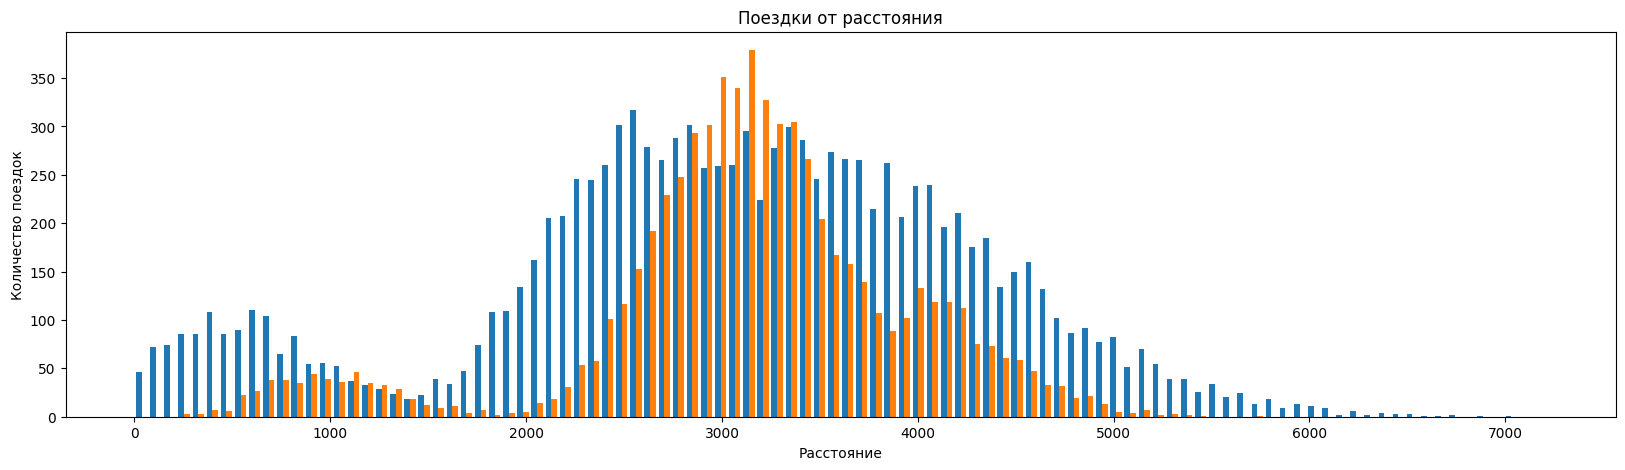

In [22]:
plt.figure(figsize=(20, 5))
plt.hist([free_go['distance'], ultra_go['distance']], bins=100, range=(1, 7211))
plt.title('Поездки от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

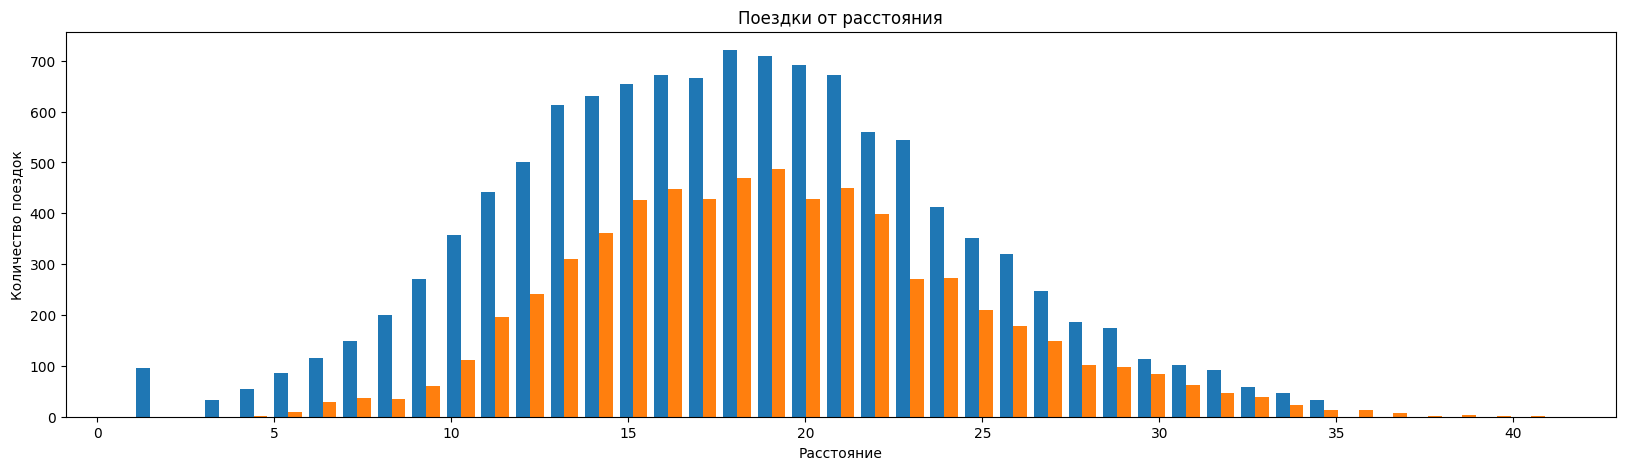

In [23]:
plt.figure(figsize=(20, 5))
plt.hist([free_go['duration'], ultra_go['duration']], bins=41, range=(1, 41))
plt.title('Поездки от расстояния')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

Вывод: Обьединил данные о пользователях, поездках и подписках в одну таблицу. Создал еще 2 таблицы о пользователях с подпиской и без. Подписка положительно влияет.

#### Шаг 5. Подсчёт выручки

5.1 Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. 5.2 В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [24]:
data_agg = data.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    trips_count=('distance', 'count'),
    total_duration=('duration', 'sum'),
    minute_price=('minute_price', 'mean'),
    start_ride_price=('start_ride_price', 'mean'),
    subscription_fee=('subscription_fee', 'mean'),
).reset_index()

data_agg['revenue'] = (
    data_agg['start_ride_price'] * data_agg['trips_count'] +
    data_agg['minute_price'] * data_agg['total_duration'] +
    data_agg['subscription_fee']
)

data_agg.head()

,user_id,month,total_distance,trips_count,total_duration,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.51,2,42,6.0,0.0,199.0,451.0
1,1,4,754.16,1,7,6.0,0.0,199.0,241.0
2,1,8,6723.47,2,46,6.0,0.0,199.0,475.0
3,1,10,5809.91,2,32,6.0,0.0,199.0,391.0
4,1,11,7003.50,3,56,6.0,0.0,199.0,535.0


#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.

In [25]:
alpha = .05

6.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

H0 - Продолжительность с подпиской = без подписки. H1 - Продолжительность с подпиской > без подписки.

In [26]:
results = st.ttest_ind(
    ultra_go['duration'],
    free_go['duration'],
    alternative='greater')

print('р-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение: 2.4959453720736625e-34
Отвергаем нулевую гипотезу


Вывод: Нулева гипотеза отвергнута. Средняя продолжительность больше с подпиской, чем без.

6.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

H0 - Среднее расстояние одной поездки с подпиской = 3130. H1 - Среднее расстояние одной поездки > 3130.

In [27]:
results = st.ttest_1samp(
    ultra_go['distance'],
    3130,
    alternative='greater')

print('р-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение: 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


Вывод: Нулевую гипотезу не удалось отвергнуть. Среднее расстояние не превышает оптимальное расстояние 3130м.

6.3 Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

H0 - Помесячная выручка с подпиской = без подписки. H1 - Помесячная выручка с подпиской > без подписки.

In [28]:
results = st.ttest_ind(
    data_agg.loc[data_agg['subscription_fee'] > 0, 'revenue'],
    data_agg.loc[data_agg['subscription_fee'] == 0, 'revenue'],
    alternative='greater')

print('р-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

р-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


Вывод: Нулевая гипотеза отвергнута. Помесячная выручка больше от пользователей с подпиской, чем без.

6.4 Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ: Тут подойдет двухвыборочный t-тест для зависимых выборок, st.ttest_rel

#### Шаг 7. Распределения

7.1 Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10% пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Минимальное количество отправленым промокодов: 1161


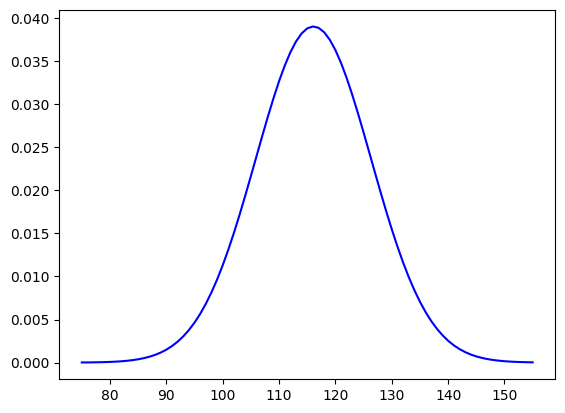

In [29]:
p = 0.1
k = 100

def find_min_n(p, k, alpha):
    n = k
    while True:
        if binom.cdf(k - 1, n, p) <= alpha:
            return n
        n += 1

min_n = find_min_n(p, k, alpha)
print('Минимальное количество отправленым промокодов:', min_n)

mu = min_n * p
sigma = math.sqrt(min_n * p * (1 - p))
left = int(mu - 4 * sigma)
right = int(mu + 4 * sigma)

arange = np.arange(left, right, 1)

plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.show()

Вывод: Необходимое количество промокодов 1161.

7.2 Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Вероятность того, что откроют: 0.15371708296369768


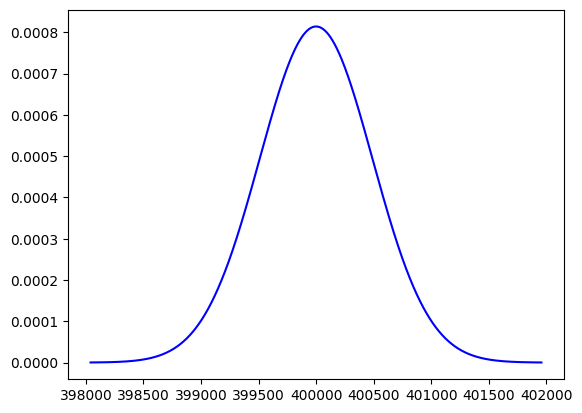

In [30]:
n = 1000000
p = 0.4
k = 399500
mu = n * p
sigma = math.sqrt(n * p *(1 - p))
left = int(mu - 4 * sigma)
right = int(mu + 4 * sigma)

distr = st.norm(mu, sigma)

print('Вероятность того, что откроют:', distr.cdf(k))

arange = np.arange(left, right, 1)
plt.plot(arange, st.norm.pdf(arange, mu, sigma), 'b-')
plt.show()

Вывод: При 1млн уведомлений с вероятность. 40%, что откроют, вероятность того, что откроют не более 399,5 тыс. пользователей состовляет 15%.

Общий вывод:
В таблицах: Пользователи - 1565 записей. Нету пропусков. Был 31 дубликат. Поездки - 18068 записей, Нету пропусков, лубликатов. Подписка - 2 записи. В таблице пользователи были удалены дубликаты, дистанцию округлили до 2 значений после запятой, продолжительность поездки откруглили до целого числа в положительную сторону. Привели дату к нужному формату и добавили столбец с месяцем. В Пятигорске чаще используют приложение, в Москве реже. Приложением чаще пользуются пез подписки. Без подписки - 835, С подпиской - 699. Средний возраст 21-28. распределение нормальное. Среднее расстояние 3070м, имеется 2 пика. Первый в районе 600м, второй 3200м. Среднее количество поездок в районе 18. У пользователей с подпиской наблюдается меньший диапазон в зависимости от расстояния и количества поездок, чем у пользователей без подписки. Гипотезы: 1)Нулева гипотеза отвергнута. Средняя продолжительность больше с подпиской, чем без. 2)Нулевую гипотезу не удалось отвергнуть. Среднее расстояние не превышает оптимальное расстояние 3130м. 3)Нулевая гипотеза отвергнута. Помесячная выручка больше от пользователей с подпиской, чем без. 4)Тут подойдет двухвыборочный t-тест для зависимых выборок, st.ttest_rel Необходимое количество промокодов 1161. При 1млн уведомлений с вероятность. 40%, что откроют, вероятность того, что откроют не более 399,5 тыс. пользователей состовляет 15%.